In [1]:
import warnings
warnings.filterwarnings('ignore')
from dotenv import load_dotenv
import os

# Cargar las variables de entorno desde el archivo .env
load_dotenv()

True

In [2]:
import mlflow
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from cubist import Cubist

In [3]:
data = pd.read_csv('../data/Steel_industry_data.csv')

# Seleccionar las columnas para la regresión
features = data.drop(columns=['date', 'Usage_kWh'])
target = data['Usage_kWh']

# param_grid = {
#     'committees': [1, 10, 20, 50],
#     'neighbors': [0, 1, 3, 5, 7],
#     'n_rules': [10, 20, 50, 100],
#     'extrapolation': [0, 0.5, 5]
# }

param_grid = {
    'regressor__n_committees': [1, 10, 20, 50],
    'regressor__neighbors': [0, 1, 3, 5, 7],
    'regressor__n_rules': [10, 20, 50, 100],
    'regressor__extrapolation': [0, 0.5, 5]
}

# Configurar la URI de seguimiento de MLflow
mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI"))

# Nombre del experimento
experiment_name = "Cubist|RandomizedSearchCV"

# Crear un experimento de MLflow
experiment_id = mlflow.create_experiment(experiment_name) if not mlflow.get_experiment_by_name(experiment_name) else mlflow.get_experiment_by_name(experiment_name).experiment_id

# Iniciar un nuevo run de MLflow
with mlflow.start_run(experiment_id=experiment_id):
    # Codificación de variables categóricas
    categorical_features = ['WeekStatus', 'Day_of_week', 'Load_Type']
    numerical_features = features.drop(columns=categorical_features).columns.tolist()
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numerical_features),
            ('cat', OneHotEncoder(), categorical_features)
        ]
    )
    
    # Configurar el modelo
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', Cubist())])
    
    # Configurar RandomizedSearchCV
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='neg_root_mean_squared_error', cv=3, verbose=2, n_iter=30, n_jobs=-1, random_state=42)
    
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    
    # Entrenar RandomizedSearchCV
    random_search.fit(X_train, y_train)
    
    mlflow.log_metric("committees",random_search.best_params_['regressor__n_committees'])
    mlflow.log_metric("neighbors",random_search.best_params_['regressor__neighbors'])
    mlflow.log_metric("n_rules",random_search.best_params_['regressor__n_rules'])
    mlflow.log_metric("extrapolation",random_search.best_params_['regressor__extrapolation'])
       
    # Mostrar los mejores parámetros y el mejor score
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best score: {random_search.best_score_}")
    
    #mlflow.log_metric("params", random_search.best_params_)
    
    # Entrenar el modelo final con los mejores parámetros
    best_model = random_search.best_estimator_
    
    # Evaluar el modelo en el conjunto de prueba
    y_pred = best_model.predict(X_test)
    
    # Calcular las métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Registrar los parámetros y métricas en MLFlow
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    
    # Registrar el modelo en MLflow
    mlflow.sklearn.log_model(best_model, "model")

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/home/lhuacho/rutaAlejandría/PUCP/2024-I/Aprendizaje Automático (INF648-0001)/.venv/lib64/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
/home/lhuacho/rutaAlejandría/PUCP/2024-I/Aprendizaje Automático (INF648-0001)/.venv/lib64/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
/home/lhuacho/rutaAlejandría/PUCP/2024-I/Aprendizaje Automático (INF648-0001)/.venv/lib64/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
/home/lhuacho/rutaAlejandría/PUCP/2024-I/Aprendizaje Automático (INF648-0001)/.venv/lib64/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
/home/lhuacho/rutaAlejan

Best parameters: {'regressor__neighbors': 5, 'regressor__n_rules': 50, 'regressor__n_committees': 50, 'regressor__extrapolation': 0.5}
Best score: -0.3959560270315088


In [4]:
print(f'mse: {mse}')
print(f'rmse: {rmse}')
print(f'mae: {mae}')
print(f'r2: {r2}')

mse: 0.07631361967507018
rmse: 0.27624919850575164
mae: 0.09234195651256878
r2: 0.9999328652062713


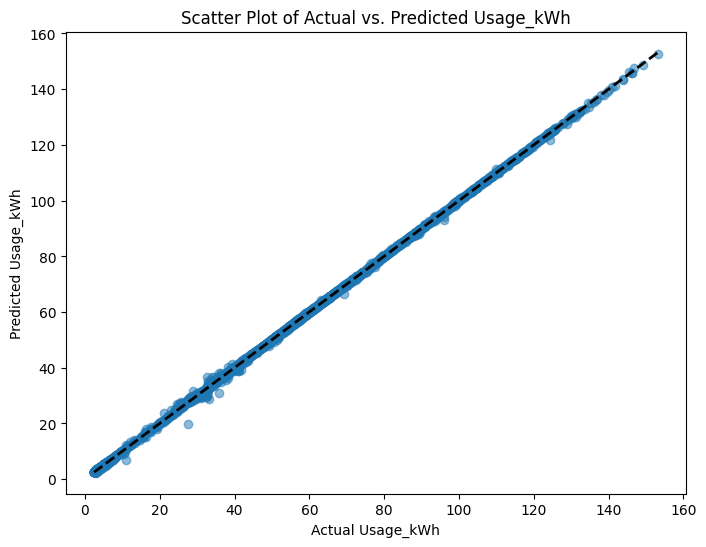

In [5]:
# Y real Vs Y pred 
plt.figure(figsize=(8, 6))
num_points = -1
plt.scatter(y_test[:num_points], y_pred[:num_points], alpha=0.5)
plt.xlabel('Actual Usage_kWh')
plt.ylabel('Predicted Usage_kWh')
plt.title('Scatter Plot of Actual vs. Predicted Usage_kWh')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()